In [1]:
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib import animation
from PIL import ImageEnhance

from tkinter import filedialog
import tkinter as tk

import pickle

from os import sys

import matplotlib.pyplot as plt
import argparse

from statistics import mean
import os

%matplotlib inline

# for loading array 
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy import signal as sig
import pandas as pd
import numpy as np
from scipy.signal import filtfilt, butter


sys.path.append(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\TheseUNIC\WorkScripts')
sys.path.append(r'C:\Users\Nicolas\Documents\GitHub\WorkScripts')

from LibrairieNico.HitsFctClass import smooth, Easyinterp, diff, calculateNewSize, getSigmoidEdgePeak, sigmoid, HighestPeakFrom
from LibrairieNico.HitFindPeacks import FindReferenceSystem2, getHIT_LINE




## Function

In [64]:
def EdgesDetectionParam(video_path, **kwargs) :
    
    
    HandleBEHAV = cv2.VideoCapture(video_path, 0)
    
    Videolength = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))
    
    
    interpMultiplicator = kwargs.get('interpMultiplicator')
    Obj_heights = kwargs.get('Obj_heights')  
    
    clipLimit = kwargs.get('clipLimit')
    tileGridSize = kwargs.get('tileGridSize')
    claheobj = cv2.createCLAHE(clipLimit, tileGridSize)  # initialize the clahe object once, to save time
    

    N  = kwargs.get('b')
    Wn = kwargs.get('a')
    b, a = butter(N, Wn) # butterworth lowpass filters initialization
    
    
    if 'filtre_acceleration' in kwargs :
        filtre_acceleration = kwargs.get('filtre_acceleration')
        
        if filtre_acceleration == False :
            pass
            
        else:
            N2  = kwargs.get('b2')
            Wn2 = kwargs.get('a2')
            b2, a2 = butter(N2, Wn2)  # butterworth lowpass filters initialization for sigmoid filtration, not used
            
    N3 = kwargs.get('b3')
    Wn3 = kwargs.get ('a3')
    b3, a3 = butter(N3, Wn3)
    
   
    ## Object dependant parameters and variables initialization ( for object 1 here with Object = 0 selected as reference system)##
              
    Object = 0
    Reference_peaks2 = FindReferenceSystem2(video_path,Obj_heights[Object])

    SliceLength = Reference_peaks2[1]-Reference_peaks2[0]
    print(f"Length of the reference slice found : {SliceLength} for the object {Object+1}.\nReference slice indices and size of peak {Reference_peaks2} (in pixel value per pixel, squared)")
    
              
    ## Sigmoid edge fitting over the whole video ( loop for one object only ) ##
    
    TimeImage = np.empty((0,SliceLength)) # initializing the "images with the slices over time, as empty numpy array to start the loop below"
    Diff_TimeImage = np.empty((0,(SliceLength*interpMultiplicator)-1)) # initializing the "images with the slices over time, as empty numpy array to start the loop below"
 
    HandleBEHAV.set(cv2.CAP_PROP_POS_FRAMES,0)

    for framne_nb in range(Videolength) :

        _ , Image = HandleBEHAV.read() # read a frame

        Slice_temp = getHIT_LINE(Image,Obj_heights[Object],Reference_peaks2[0:2],reverse = True, clahe = True, axis = 1) 
        # getHIT_LINE function process the frame to reverse pixels colors, do clahe eventually, and extract the slice needed to perform the analysis 

        TimeImage = np.append(TimeImage, Slice_temp ,axis = 0 )
        # appending the slice to make the grey image shown in the first plot in figure 2

        DiffSlice_temp, Fit = getSigmoidEdgePeak(Slice_temp, lowpass_raw = [b, a], filtre_acceleration  = False, interp = interpMultiplicator )
        # getSigmoidEdgePeak function process the slice to filter, fit a sigmoid, derivate this sigmoid, filter again to be sure the signal is clean, with one nice "gaussian like" peak, and return the result

        Diff_TimeImage = np.append(Diff_TimeImage, DiffSlice_temp ,axis = 0)
        
    if framne_nb == 1:
        fig = plt.figure(figsize = (40,20))

        plt.subplot(231)######################
        plt.imshow(Slice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Raw slice around object",fontsize = 30)
        
        ax = plt.subplot(232)######################
        plt.imshow(DiffSlice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Sigmoid fit derivative, as a proxy for edge center",fontsize = 30)
        
        ax = plt.subplot(234)######################
        plt.plot(Slice_temp.flatten())
        plt.plot(np.arange(0,np.shape(Slice_temp)[1],1/interpMultiplicator),Fit.flatten())
        plt.title("Profile of the above figure in blue, and sigmoid fit in orange",fontsize = 30)
        
        ax = plt.subplot(235)######################
        plt.plot(DiffSlice_temp.flatten())
        plt.title("Profile of the above figure",fontsize = 30)
    
    ## Extracting coordinates of edge sigmoids ##
    edges = []
    for I in range(np.shape(Diff_TimeImage)[0]):

        DPeaks , values = sig.find_peaks(Diff_TimeImage[I,:], height = 1/interpMultiplicator)
        DPeaks,values = HighestPeakFrom(DPeaks,values)
        edges.append(DPeaks)

    edges = np.asarray(edges).astype(float)
    edges = edges/interpMultiplicator
    mean = np.nanmean(edges)
    print(f"Mean of the values for the edge detected over time :{mean}")
    
    PeakColor = 'red'
    plt.subplot(236)######################
    plt.imshow(Diff_TimeImage, 'ocean', extent=[0,33,500,0], aspect=1)
    plt.plot(edges-1,np.arange(0,len(edges),1),PeakColor)
    plt.title("Derivative of Sigmoid fit",fontsize = 20)
    
    edges_Obj1 = np.copy(edges)
    
    
## Obj 2 ## 

    Object = 1
    Reference_peaks2 = FindReferenceSystem2(video_path,Obj_heights[Object])

    SliceLength = Reference_peaks2[1]-Reference_peaks2[0]
    print(f"Length of the reference slice found :{SliceLength} for the object {Object+1}.\nReference slice indices and size of peak {Reference_peaks2} (in pixel value per pixel, squared)")



### Sigmoid edge fitting over the whole video ( loop for one object only ) ##

    TimeImage = np.empty((0,SliceLength))
    Diff_TimeImage = np.empty((0,(SliceLength*interpMultiplicator)-1))
    
    HandleBEHAV.set(cv2.CAP_PROP_POS_FRAMES,0)
    
    for framne_nb in range(Videolength) :

        _ , Image = HandleBEHAV.read()

        Slice_temp = getHIT_LINE(Image,Obj_heights[Object],Reference_peaks2[0:2],reverse = True, clahe = True, axis = 1)

        TimeImage = np.append(TimeImage, Slice_temp ,axis = 0 )

        DiffSlice_temp, Fit = getSigmoidEdgePeak(Slice_temp, lowpass_raw = [b, a], filtre_acceleration = False, interp = interpMultiplicator )

        Diff_TimeImage = np.append(Diff_TimeImage, DiffSlice_temp ,axis = 0)

        if framne_nb == 1:
            fig = plt.figure(figsize = (40,20))

            PeakColor = 'red'

            plt.subplot(231)######################
            plt.imshow(Image, 'gray')
            plt.plot([0,np.shape(Image)[1]],[Obj_heights[Object],Obj_heights[Object]],PeakColor)
            plt.plot([Reference_peaks2[0],Reference_peaks2[0]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
            plt.plot([Reference_peaks2[1],Reference_peaks2[1]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
            plt.title("Detecting highest peak in the derivative of\nimage values along an horizontal slice (red) to\ndetermine 2nd object approximative coordinates",fontsize = 30)

            plt.subplot(232)######################
            plt.imshow(Slice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
            plt.title("Raw slice around object",fontsize = 30)

            ax = plt.subplot(233)######################
            plt.imshow(DiffSlice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
            plt.title("Sigmoid fit derivative, as a proxy for approximate edge center",fontsize = 30)

            ax = plt.subplot(235)######################
            plt.plot(Slice_temp.flatten())
            plt.plot(np.arange(0,np.shape(Slice_temp)[1],1/interpMultiplicator),Fit.flatten())
            plt.title("Profile of the above figure in blue, and sigmoid fit in orange",fontsize = 30)

            ax = plt.subplot(236)######################
            plt.plot(DiffSlice_temp.flatten())
            plt.title("Profile of the above figure",fontsize = 30)
        

    ##Extracting coordinates of edge sigmoids##
    
    edges = []
    for I in range(np.shape(Diff_TimeImage)[0]):

        DPeaks , values = sig.find_peaks(Diff_TimeImage[I,:], height = 1/interpMultiplicator)
        DPeaks,values = HighestPeakFrom(DPeaks,values)
        edges.append(DPeaks)

    edges = np.asarray(edges).astype(float)
    edges = edges/interpMultiplicator
    mean = np.nanmean(edges)
    print(f"Mean of the values for the edge detected over time :{mean}")
    
    
    #fig = plt.figure(figsize = (20,20))
    #plt.plot######################
    #plt.imshow(Diff_TimeImage, 'ocean', extent=[0,33,500,0], aspect=1)
    #plt.plot(edges-1,np.arange(0,len(edges),1),PeakColor)
    #plt.title("Derivative of Sigmoid fit",fontsize = 20)
    
    
    ###################
    
    edges_Obj2 = np.copy(edges)
    
    obj1mean = np.nanmean(edges_Obj1)
    obj2mean = np.nanmean(edges_Obj2)
    
    filtobj1 = filtfilt(b3, a3, edges_Obj1)  
    filtobj2 = filtfilt(b3, a3, edges_Obj2)  


    MetaEDGE = edges_Obj1 - edges_Obj2
    MetaMean = np.nanmean(MetaEDGE)

    MetaEDGE_filt = filtobj1 - filtobj2

    fig = plt.figure(figsize = (30,30))

    plt.subplot(231)######################
    plt.plot(edges_Obj1,np.arange(len(edges_Obj1),0,-1),PeakColor)
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(obj1mean-10,obj1mean+10)
    plt.plot([obj1mean-3,obj1mean-3],[0,500],'blue')
    plt.plot([obj1mean+3,obj1mean+3],[0,500],'blue')
    plt.title("Oscilation obtained from Object 1",fontsize = 20)

    plt.subplot(232)######################
    plt.plot(edges_Obj2,np.arange(len(edges_Obj2),0,-1),PeakColor)
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(obj2mean-10,obj2mean+10)
    plt.plot([obj2mean-3,obj2mean-3],[0,500],'blue')
    plt.plot([obj2mean+3,obj2mean+3],[0,500],'blue')
    plt.title("Oscilation obtained from Object 2",fontsize = 20)

    plt.subplot(233)######################
    plt.plot(MetaEDGE,np.arange(len(MetaEDGE),0,-1),PeakColor)
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(MetaMean-10,MetaMean+10)
    plt.plot([MetaMean-3,MetaMean-3],[0,500],'blue')
    plt.plot([MetaMean+3,MetaMean+3],[0,500],'blue')
    plt.title("Oscilation obtained from susbtraction\nof both edges movements over time",fontsize = 20)

    plt.subplot(234)######################
    plt.plot(filtobj1,np.arange(len(edges_Obj1),0,-1),PeakColor)
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(obj1mean-10,obj1mean+10)
    plt.plot([obj1mean-3,obj1mean-3],[0,500],'blue')
    plt.plot([obj1mean+3,obj1mean+3],[0,500],'blue')
    plt.title("Oscilation obtained from Object 1 (filtered)",fontsize = 20)

    plt.subplot(235)######################
    plt.plot(filtobj2,np.arange(len(edges_Obj2),0,-1),PeakColor)
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(obj2mean-10,obj2mean+10)
    plt.plot([obj2mean-3,obj2mean-3],[0,500],'blue')
    plt.plot([obj2mean+3,obj2mean+3],[0,500],'blue')
    plt.title("Oscilation obtained from Object 2  (filtered)",fontsize = 20)

    plt.subplot(236)######################
    plt.plot(MetaEDGE_filt,np.arange(len(MetaEDGE),0,-1),'green')
    plt.ylabel("time",fontsize = 15)
    plt.xlabel("pixels",fontsize = 15)
    plt.ylim(0,500)
    plt.xlim(MetaMean-10,MetaMean+10)
    plt.plot([MetaMean-3,MetaMean-3],[0,500],'blue')
    plt.plot([MetaMean+3,MetaMean+3],[0,500],'blue')
    plt.title("Oscilation obtained from susbtraction\nof both edges movements over time  (filtered)",fontsize = 20)

    plt.savefig("fig5.png")
    plt.show()
    
    
    
    return MetaEDGE

## Shifting of the object at the end of the video is removed from signal ! EUREKA !

Declaration des Kwargs : b, a = filtre butterwork pour objet 1 ; b = 3,  a = 0.100 ///
                       : b2, a2 pas utilisés --> filtrage de la curve fit (ancienne valeurs b2 = 3, a2 = 0.300)///
                       : b3, a3 = filtre butterwork de l'objet 2 ; b = 7 et a = 0.400///


C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Length of the reference slice found : 40 for the object 1.
Reference slice indices and size of peak [345, 385, 1.0300000000000007] (in pixel value per pixel, squared)
Mean of the values for the edge detected over time :14.795200000000001
Length of the reference slice found :33 for the object 2.
Reference slice indices and size of peak [1247, 1280, 1.0000000000000007] (in pixel value per pixel, squared)


C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Mean of the values for the edge detected over time :13.478599999999998


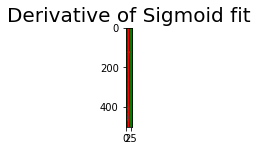

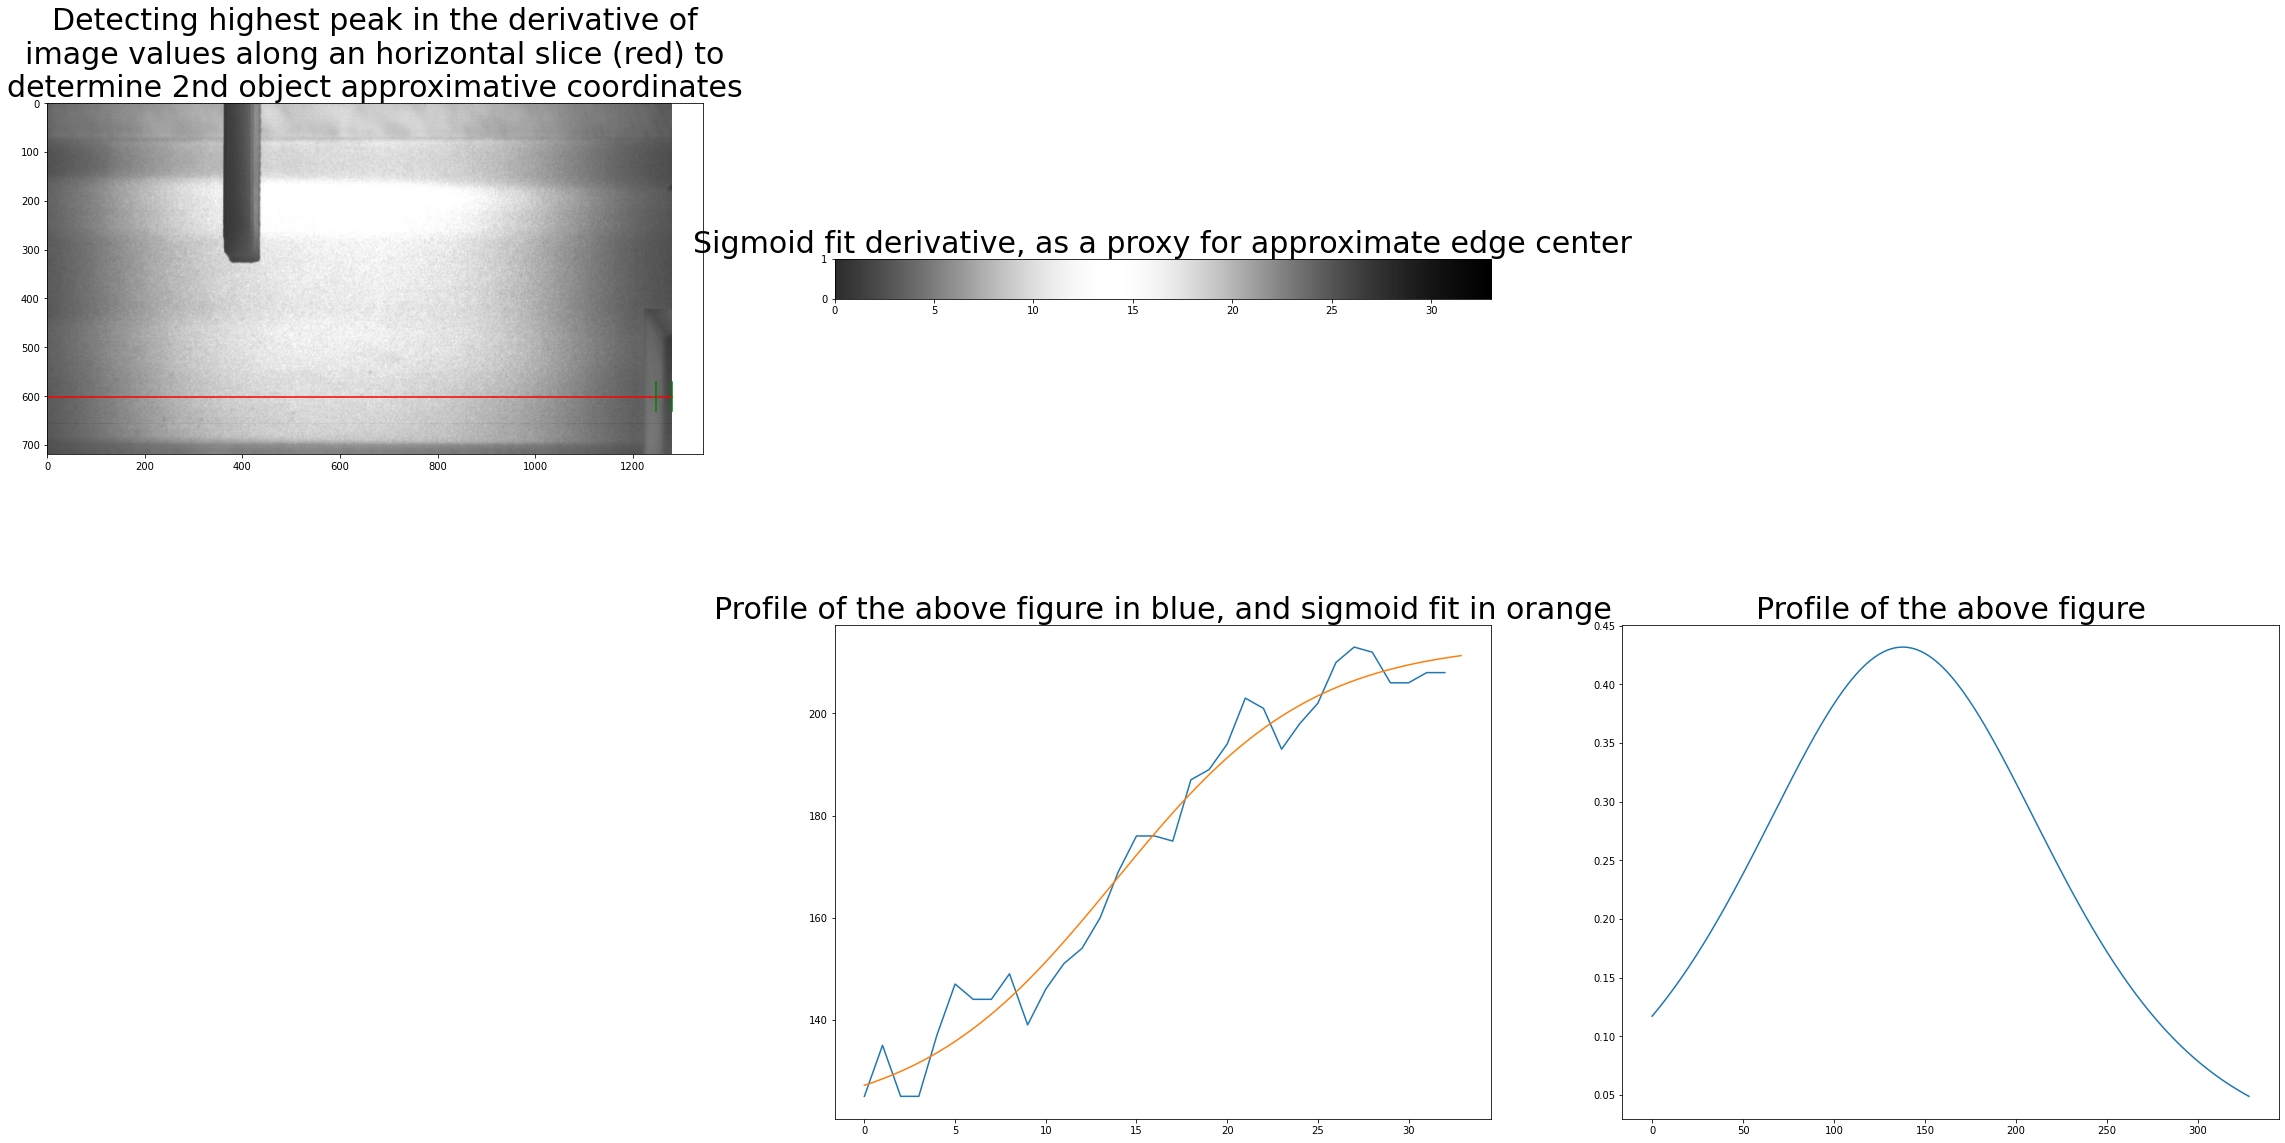

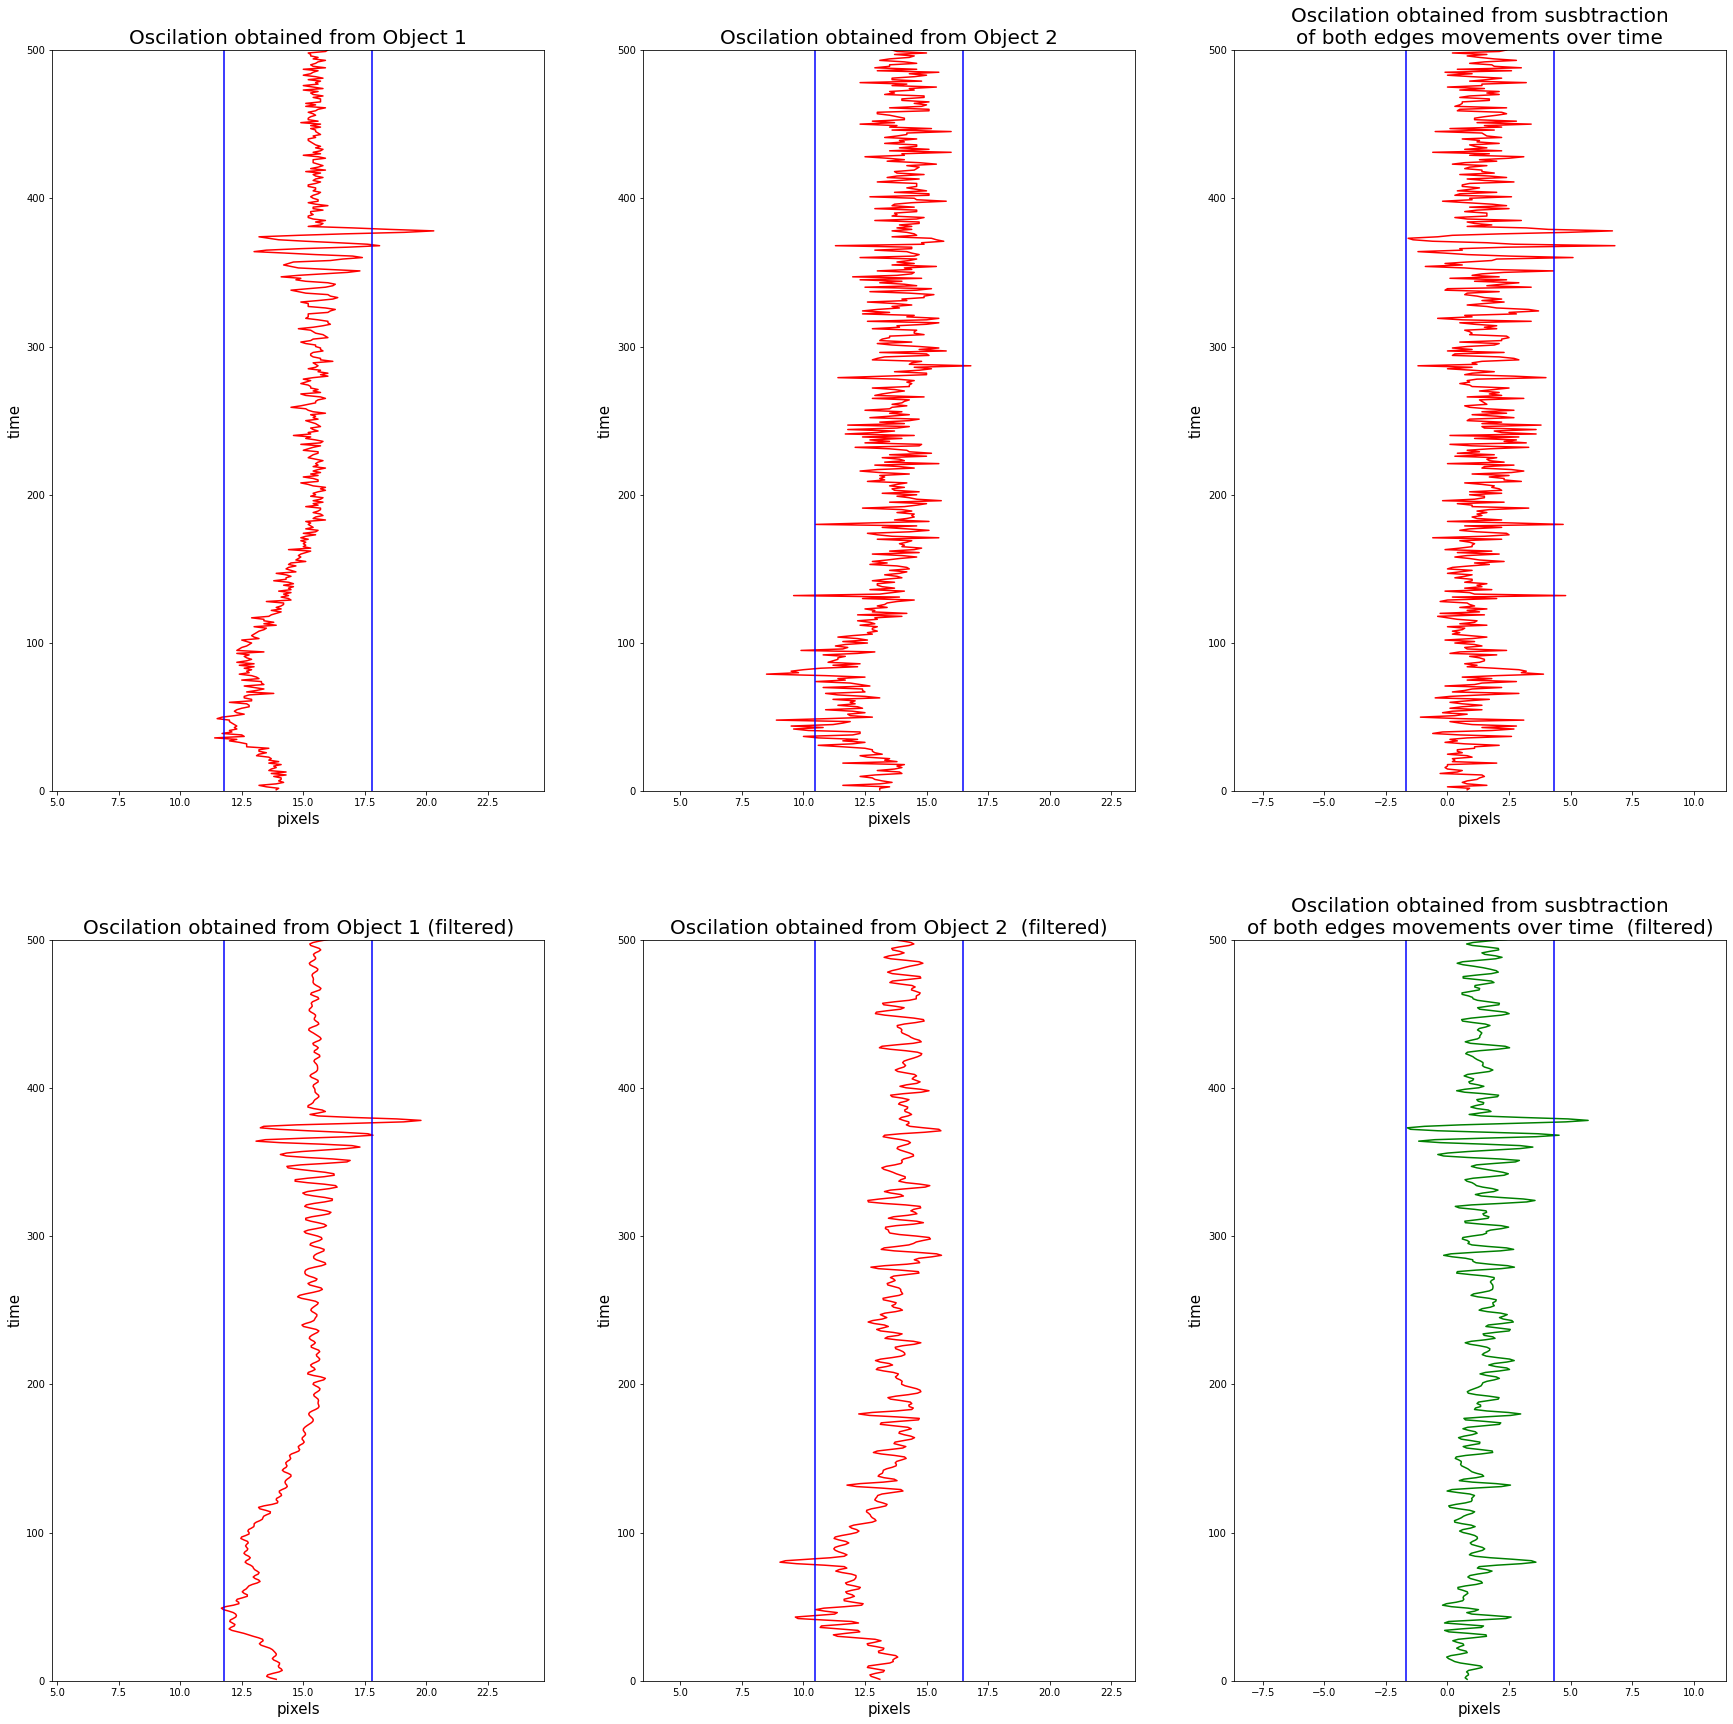

array([ 2.4,  2.1,  0.2,  1.6,  0.8,  1.3,  1.9,  2.8,  1.5,  0.9,  1.8,
        1.9,  3. ,  0.4,  2.6, -0.1,  1. ,  0. ,  1. ,  2.2,  1.6,  0.9,
        3.2,  1.4,  1.4,  0. ,  1.5,  0.5,  2.1,  1.6,  2.1,  0.9,  0.5,
        1.7,  1.7,  0.6,  0.6,  0.5,  0.3,  2.4,  0.5,  0.4,  2.2,  2.4,
        2. ,  1.5,  1.1,  1.1,  2.8,  1.2,  3.4,  1.5,  2.2,  0.1,  1.9,
       -0.5,  1.4,  1.5,  1.6,  2.2,  0.6,  1.3,  1.2,  2.1,  0.9,  1.1,
        1.6,  0.7,  2.2, -0.6,  1.7,  0.9,  3.1,  2.5,  1.3,  2. ,  0.7,
        0.2,  1.6,  0.9,  0.7,  1.4,  1.4,  1.9,  0.5,  1.7,  2.4,  0.8,
        1.5,  2.7,  0.9,  0.6,  0.6,  1.3,  0.9,  0.4,  2. ,  0.5,  0.3,
        2.6,  0.9,  1. , -0.2,  0.8,  1.8,  2.4,  0.9,  2.5,  1.2,  0.7,
        1.6,  1.6,  1.6,  0.3,  0.8,  3. ,  0.8,  1.1,  1.8,  0.8,  3.2,
        4.1,  6.7,  4.9,  2.2,  0.2, -0.4, -1.6, -1.4, -0.6,  1.6,  2.7,
        6.8,  2.4,  0.5,  0.6, -1.2, -0.1,  0.8,  2.5,  5.1,  2. ,  1.8,
        0.8, -0.1,  0.6, -0.9,  0.7,  1.6,  4.3,  2

In [65]:
## Test pour videos
video_path = r"C:\Users\Nicolas\Desktop\Test_Hit\Mouse25_2020-02-07T11.13.18.avi"

EdgesDetectionParam(video_path, interpMultiplicator = 10, Obj_heights = [140,601] , clipLimit=2.0, tileGridSize=(32,32), b = 3,  a = 0.100, filtre_acceleration = False, b3 = 7 , a3 = 0.400 )

